<a href="https://colab.research.google.com/github/AlMarNeuro/AlMarNR/blob/media108/Stajirovka_Media108_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Описание содержимого ноутбука

- Проверка расшифровки в текст нецелевого звонка сервисом Nvidia Nemo
- Анализ в CSV Романа поля "Теги" на целевой/нецелевой
- Подготовка данных для обучения решению распознавания целевой/нецелевой на выборке обощённых параметров описания аудиосигнала
  - предобработка с формированием датафрейма теги + аудио для расчёта и сохранение параметров аудиосигнала, преобразуемых на след. шаге в датасет для обучения (для отработки моделей взята выборка Headliner)

## Инициализация

In [ ]:
# Подключение google-диска
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
# Параметры отображения датафреймов
pd.options.display.max_rows     = 99
pd.options.display.max_colwidth = 999
import numpy as np
import regex as re
import librosa # Для параметризации аудио
import librosa.display # Для отображения аудио сигналов
import sklearn # Для нормирования
from sklearn.preprocessing import StandardScaler # Масштабирование данных
import matplotlib.pyplot as plt # Для отрисовки графиков
plt.style.use('dark_background')
from google.colab import files # Для загрузки файлов
import IPython.display as ipd # Для проигрывания аудио
from IPython.display import Audio
import seaborn as sns
%matplotlib inline

In [ ]:
# Глобальные переменные
VM_CNT = '/content'
VM_CNT_DRV = VM_CNT + '/drive'
MY_CNT = '/content/drive/MyDrive/УИИ(marphida)/Стажировка_Media108'

WAV_PATH = VM_CNT_DRV + '/MyDrive/УИИ(marphida)/Стажировка_Media108/Audio/'
WAV_FILE = '2023-07-16_19-33-07.854622_from_79254254955_to_0111642_session_3091299879_talk.wav'
WAV_DATA = WAV_PATH + WAV_FILE

WAV_PRIMA = MY_CNT + '/Audio/Записи звонков_primavera/'
WAV_PAVEL_ST = MY_CNT + '/Audio/Записи звонков_павелецкая сити'
WAV_PAVEL_HL = MY_CNT + '/Audio/Записи звонков_хедлайнер'
WAV_ZV_INFO = MY_CNT + '/Audio/Информация о звонках'

DF_HL = MY_CNT + '/РГ/Headliner_df.pkl'
DF_PAVEL_ST = MY_CNT + '/РГ/Paveletskaya_city_df.pkl'
DF_PAVEL_HL = MY_CNT + '/РГ/Paveletskaya_df.pkl'
DF_PRIMA = MY_CNT + '/РГ/Primavera_df.pkl'
DF_TOTAL = MY_CNT + '/РГ/total_df.pkl'
DF_TOTAL_MATCH = MY_CNT + '/РГ/total_match_df.pkl'
DF_TOTAL_NOT_MATCH = MY_CNT + '/РГ/total_not_match_df.pkl'

CSV_HL = MY_CNT + '/РП/Headliner_with_audio.csv'
CSV_PST = MY_CNT + '/РП/Павелецкая_ЖК_«Павелецкая_сити»_with_audio.csv'
CSV_PTB = MY_CNT + '/РП/Paveleckaya_with_audio.csv'
CSV_PRM = MY_CNT + '/РП/Primavera_with_audio.csv'


## Проверка качества SpeechToText Nvidia Nemo

In [ ]:
pip install nemo_toolkit['all']

In [ ]:
import nemo.collections.asr as nemo_asr
asr_model = nemo_asr.models.EncDecRNNTBPEModel.from_pretrained("nvidia/stt_ru_conformer_transducer_large")

[NeMo I 2023-09-30 13:37:35 mixins:170] Tokenizer SentencePieceTokenizer initialized with 1024 tokens


[NeMo W 2023-09-30 13:37:36 modelPT:161] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    sample_rate: 16000
    batch_size: 16
    shuffle: true
    num_workers: 8
    pin_memory: true
    use_start_end_token: false
    trim_silence: false
    max_duration: 20.0
    min_duration: 0.1
    is_tarred: false
    tarred_audio_filepaths: null
    shuffle_n: 2048
    bucketing_strategy: synced_randomized
    bucketing_batch_size: null
    bucketing_weights: ''
    
[NeMo W 2023-09-30 13:37:36 modelPT:168] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: null
    sample_rate: 16000
    batch_size: 16
    shuffle: fals

[NeMo I 2023-09-30 13:37:36 features:289] PADDING: 0


[NeMo W 2023-09-30 13:37:38 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
      warnings.warn("dropout option adds dropout after all but last "
    


[NeMo I 2023-09-30 13:37:38 rnnt_models:211] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'fastemit_lambda': 0.0, 'clamp': -1.0}
[NeMo I 2023-09-30 13:37:39 save_restore_connector:249] Model EncDecRNNTBPEModel was successfully restored from /root/.cache/huggingface/hub/models--nvidia--stt_ru_conformer_transducer_large/snapshots/687d02db291e931455cf321abd625ef2b7f0b1a9/stt_ru_conformer_transducer_large.nemo.


In [ ]:
type(WAV_DATA)

str

In [ ]:
import librosa
y, sr = librosa.load(WAV_DATA)

In [ ]:
z = librosa.resample(y, orig_sr=22050, target_sr=16000)

In [ ]:
!pip install pydub

In [ ]:
from pydub import AudioSegment
wav8 = AudioSegment.from_file(file=WAV_DATA, format='wav')
print(type(wav8))

# продолжительность аудио (секунды)
print(wav8.duration_seconds)

# частота дискретизаци
print(wav8.frame_rate)

# количество каналов
print(wav8.channels)

<class 'pydub.audio_segment.AudioSegment'>
27.653875
8000
2


In [ ]:
wav9 = wav8.set_frame_rate(16000)
mono9 = wav9.split_to_mono()
mono9[0].export("media1.wav", format="wav")

<_io.BufferedRandom name='media1.wav'>

In [ ]:
asr_model.transcribe(['media1.wav'])
# asr_model.transcribe([z])

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

(['кладный город на реке прямо врата добрый а можно по поводу оценки машины в проектор ну вы сейчас звоните в отделе продажего комплекса выра мы занимаем из продажи квартир я звоню очень извините ради бога я понял'],
 ['кладный город на реке прямо врата добрый а можно по поводу оценки машины в проектор ну вы сейчас звоните в отделе продажего комплекса выра мы занимаем из продажи квартир я звоню очень извините ради бога я понял'])



---



## CSV Романа

In [ ]:
# Headliner
df_hl = pd.read_csv(CSV_HL)
print(f'df_hl.shape = {df_hl.shape}')
# Paveletskaya_city
df_pst = pd.read_csv(CSV_PST)
print(f'df_pst.shape = {df_pst.shape}')
# Paveletskaya_turbo
df_ptb = pd.read_csv(CSV_PTB)
print(f'df_ptb.shape = {df_ptb.shape}')
# Primavera
df_pri = pd.read_csv(CSV_PRM)
print(f'df_pri.shape = {df_pri.shape}')

df_hl.shape = (2045, 73)
df_pst.shape = (1000, 76)
df_ptb.shape = (1784, 76)
df_pri.shape = (1517, 75)


In [ ]:
df_hl['Теги'].unique().tolist()

['Первичный целевой - 3 очередь - 1-ком',
 'спорный - нет соединения',
 'спорный - номер взят не дозвонились  до ОП',
 'постпродажное обслуживание - Условно целевой - Б.хаус',
 'спорный - клиент просил перезвонить',
 'постпродажное обслуживание - i love - Условно целевой',
 'повторная покупка - Вторичный целевой - 2 очередь - 1-ком',
 'Первичный целевой - 2 очередь - 3 очередь - 2-ком',
 'Лид - не проходит по бюджету - 3 очередь - Условно целевой - 1-ком',
 '3 очередь - 2-ком - Условно целевой',
 'спорный - связь прервалась',
 'Первичный целевой - студия - 3 очередь',
 'Нецелевой звонок - сотрудничество',
 'тест',
 'Вторичный целевой - 2 очередь - 2-ком - балкон - 3-ком',
 'Первичный целевой - ипотека - студия - 3 очередь',
 'повторная покупка - Вторичный целевой - 2 очередь - 3 очередь - 1-ком',
 'Нецелевой звонок - ошибка',
 'i love - 2-ком - Условно целевой',
 'интересуют скидки - Первичный целевой - 1 очередь - 2-ком',
 'постпродажное обслуживание - Вторичный целевой',
 'Первичный 

In [ ]:
df_hl['Аудиофайл']

0       2023-07-19_17-12-58.258412_from_79991345109_to_74959339902_session_3099072526_talk.mp3
1           2023-07-19_17-11-07.982207_from_79991345109_to_0188880_session_3098403244_talk.mp3
2       2023-07-19_17-01-54.812316_from_79835094068_to_74959339902_session_3099032036_talk.mp3
3       2023-07-19_16-52-13.751207_from_79152403560_to_74959339929_session_3099003691_talk.mp3
4       2023-07-19_16-51-00.801138_from_79161024742_to_74959339902_session_3098339039_talk.mp3
                                                 ...                                          
2040        2023-05-08_12-51-38.868213_from_74997040921_to_0188880_session_2928283255_talk.mp3
2041        2023-05-08_12-35-55.567230_from_79622801999_to_0188880_session_2938080128_talk.mp3
2042        2023-05-08_12-34-46.730988_from_79622801999_to_0188880_session_2928807121_talk.mp3
2043        2023-05-08_11-43-52.513973_from_79827693228_to_0188880_session_2937971588_talk.mp3
2044    2023-05-08_10-41-56.911054_from_7925081717

## Датафреймы Руслана

In [ ]:
# Headliner
df_hl = pd.read_pickle(DF_HL)
df_hl.to_csv(VM_CNT + '/Headliner_df.csv', index=False)
print(f'type(Headliner) = {type(df_hl)}')
print(f'df_hl.shape = {df_hl.shape}')
# Paveletskaya_city
df_pst = pd.read_pickle(DF_PAVEL_ST)
df_pst.to_csv(VM_CNT + '/Paveletskaya_city_df.csv', index=False)
print(f'type(Paveletskaya_city) = {type(df_pst)}')
print(f'df_pst.shape = {df_pst.shape}')
# Paveletskaya
df_phl = pd.read_pickle(DF_PAVEL_HL)
df_phl.to_csv(VM_CNT + '/Paveletskaya_df.csv', index=False)
print(f'type(Paveletskaya) = {type(df_phl)}')
print(f'df_phl.shape = {df_phl.shape}')
# Primavera
df_pri = pd.read_pickle(DF_PRIMA)
df_pri.to_csv(VM_CNT + '/Primavera_df.csv', index=False)
print(f'type(Primavera) = {type(df_pri)}')
print(f'df_pri.shape = {df_pri.shape}')

type(Headliner) = <class 'pandas.core.frame.DataFrame'>
df_hl.shape = (4759, 75)
type(Paveletskaya_city) = <class 'pandas.core.frame.DataFrame'>
df_pst.shape = (9327, 75)
type(Paveletskaya) = <class 'pandas.core.frame.DataFrame'>
df_phl.shape = (1211, 75)
type(Primavera) = <class 'pandas.core.frame.DataFrame'>
df_pri.shape = (3506, 75)


In [ ]:
df_hl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4759 entries, 0 to 4758
Data columns (total 75 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   Статус                                   4759 non-null   object        
 1   Тип                                      4759 non-null   object        
 2   Дата и время                             4759 non-null   datetime64[ns]
 3   Номер абонента                           4759 non-null   int64         
 4   Рекламная кампания                       4759 non-null   object        
 5   Длительность звонка                      4759 non-null   object        
 6   Длительность ожидания ответа             4759 non-null   object        
 7   Сотрудник                                4759 non-null   object        
 8   UTM-метка Campaign                       4759 non-null   object        
 9   Теги                                     

In [ ]:
df_hl

Статус                       Тип        Дата и время  \
0       Принятый               Звонок ВАТС 2023-05-01 09:44:05   
1       Принятый               Звонок ВАТС 2023-05-01 11:24:16   
2       Принятый  Динамический коллтрекинг 2023-05-01 12:26:22   
3       Принятый  Динамический коллтрекинг 2023-05-01 15:19:49   
4       Принятый               Звонок ВАТС 2023-05-01 16:43:57   
...          ...                       ...                 ...   
4754    Принятый   Автоперезвон по заявкам 2023-07-31 14:46:50   
4755  Потерянный               Звонок ВАТС 2023-07-31 15:52:11   
4756    Принятый               Звонок ВАТС 2023-07-31 15:54:00   
4757    Принятый               Звонок ВАТС 2023-07-31 19:06:54   
4758    Принятый               Звонок ВАТС 2023-07-31 20:51:16   

      Номер абонента                                 Рекламная кампания  \
0        79777662131      Медийная реклама // kvartirny-control // Спец   
1        79643463441                                      Базы // Avito   
2        74991352444                                     Яндекс Дисплей   
3        79268860117                                      Яндекс Директ   
4        79859404929  Медийная реклама // Roomberry // звонок с карт...   
...              ...                                                ...   
4754     79180631750                              Поисковое продвижение   
4755     79272212507                           Офис заселения Хедлайнер   
4756     79687385969               Медийная реклама // realty // Звонок   
4757     79257835550                                     Звонки_оффлайн   
4758     79990016333                                  Google мой бизнес   

     Длительность звонка Длительность ожидания ответа  \
0               00:08:33                     00:00:01   
1               00:00:35                     00:00:31   
2               00:00:11                     00:00:05   
3               00:01:55                     00:00:13   
4               00:00:57                     00:00:00   
...                  ...                          ...   
4754            00:01:45                     00:00:30   
4755            00:00:31                     00:00:31   
4756            00:01:23                     00:00:01   
4757            00:03:12                     00:00:10   
4758            00:02:50                     00:00:00   

                         Сотрудник                        UTM-метка Campaign  \
0     Метриум Вертушка 74997552563                                       нет   
1     Метриум Вертушка 74997552563                                       нет   
2        Capital 7 (495) 960 77 74                                       нет   
3                        Capital 2  brend_search_mmo_apartment_site|85809506   
4                          Кортрос                                       нет   
...                            ...                                       ...   
4754                       Кортрос                                       нет   
4755                нет сотрудника                                       нет   
4756                       Кортрос                                       нет   
4757                     Capital 2                                       нет   
4758                       Кортрос                                       нет   

                                                   Теги  ...  \
0     Первичный целевой - 2 очередь - ипотека - 3 оч...  ...   
1                              спорный - нет соединения  ...   
2                              спорный - нет соединения  ...   
3     Первичный целевой - 2 очередь - запись на прос...  ...   
4        Лид - ПБ - 2 очередь - 2-ком - Условно целевой  ...   
...                                                 ...  ...   
4754     постпродажное обслуживание - Вторичный целевой  ...   
4755                           спорный - нет соединения  ...   
4756  спорный - номер взят не дозвонились  до ОП - 4...  ...   
4757  Первичный целевой - 2 оч

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df, *['Номер абонента'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df, *['Номер обращения'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df, *['Виртуальный номер'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df, *['ID посетителя'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df, *['Номер абонента'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df, *['Номер обращения'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df, *['Виртуальный номер'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df, *['ID посетителя'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(df, *['Статус'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(df, *['Тип'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(df, *['Причина завершения'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(df, *['UTM-метка Medium'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 6 * figscale, 6 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(df, *[[['Номер абонента', 'Номер обращения'], ['Номер обращения', 'Виртуальный номер'], ['Виртуальный номер', 'ID посетителя'], ['ID посетителя', 'Номер сотрудника']]], **{})
chart

import numpy as np
from google.colab import autoviz

def heatmap(df, x_colname, y_colname, figscale=1, mpl_palette_name='viridis'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  import pandas as pd
  plt.subplots(figsize=(8 * figscale, 8 * figscale))
  df_2dhist = pd.DataFrame({
      x_label: grp[y_colname].value_counts()
      for x_label, grp in df.groupby(x_colname)
  })
  sns.heatmap(df_2dhist, cmap=mpl_palette_name)
  plt.xlabel(x_colname)
  plt.ylabel(y_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = heatmap(df, *['Статус', 'Тип'], **{})
chart

import numpy as np
from google.colab import autoviz

def heatmap(df, x_colname, y_colname, figscale=1, mpl_palette_name='viridis'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  import pandas as pd
  plt.subplots(figsize=(8 * figscale, 8 * figscale))
  df_2dhist = pd.DataFrame({
      x_label: grp[y_colname].value_counts()
      for x_label, grp in df.groupby(x_colname)
  })
  sns.heatmap(df_2dhist, cmap=mpl_palette_name)
  plt.xlabel(x_colname)
  plt.ylabel(y_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = heatmap(df, *['Тип', 'Причина завершения'], **{})
chart

import numpy as np
from google.colab import autoviz

def heatmap(df, x_colname, y_colname, figscale=1, mpl_palette_name='viridis'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  import pandas as pd
  plt.subplots(figsize=(8 * figscale, 8 * figscale))
  df_2dhist = pd.DataFrame({
      x_label: grp[y_colname].value_counts()
      for x_label, grp in df.groupby(x_colname)
  })
  sns.heatmap(df_2dhist, cmap=mpl_palette_name)
  plt.xlabel(x_colname)
  plt.ylabel(y_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = heatmap(df, *['Причина завершения', 'UTM-метка Medium'], **{})
chart

import numpy as np
from google.colab import autoviz

def heatmap(df, x_colname, y_colname, figscale=1, mpl_palette_name='viridis'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  import pandas as pd
  plt.subplots(figsize=(8 * figscale, 8 * figscale))
  df_2dhist = pd.DataFrame({
      x_label: grp[y_colname].value_counts()
      for x_label, grp in df.groupby(x_colname)
  })
  sns.heatmap(df_2dhist, cmap=mpl_palette_name)
  plt.xlabel(x_colname)
  plt.ylabel(y_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = heatmap(df, *['UTM-метка Medium', 'Страна номера абонента'], **{})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(df, *['Номер абонента', 'Статус'], **{'inner': 'box'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(df, *['Номер абонента', 'Тип'], **{'inner': 'box'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(df, *['Номер абонента', 'Причина завершения'], **{'inner': 'box'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(df, *['Номер абонента', 'UTM-метка Medium'], **{'inner': 'box'})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df, *['Дата и время', 'Номер абонента', 'Статус'], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df, *['Дата и время', 'Номер абонента', 'Тип'], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df, *['Дата и время', 'Номер абонента', 'Причина завершения'], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df, *['Дата и время', 'Номер абонента', 'UTM-метка Medium'], **{})
chart

In [ ]:
df_hl[df_hl['Файл записи звонка']=='нет файла'].count()

Статус                   2714
Тип                      2714
Дата и время             2714
Номер абонента           2714
Рекламная кампания       2714
                         ... 
OS-метка service-name    2714
OS-метка campaign-id     2714
OS-метка ad-id           2714
OS-метка source-id       2714
Файл записи звонка       2714
Length: 75, dtype: int64



---



## Подготовка данных для формирования обучающей выборки

In [ ]:
df_hl['Теги'].describe()

count                         2045
unique                         398
top       спорный - нет соединения
freq                           796
Name: Теги, dtype: object

In [ ]:
df_hl['Аудиофайл'].describe()

count                                                                                       2045
unique                                                                                      2045
top       2023-07-19_17-12-58.258412_from_79991345109_to_74959339902_session_3099072526_talk.mp3
freq                                                                                           1
Name: Аудиофайл, dtype: object

In [ ]:
df_hl[df_hl['Теги'].str.contains('Нецелевой')]['Теги'].describe()

count                           118
unique                           15
top       Нецелевой звонок - ошибка
freq                             77
Name: Теги, dtype: object

In [ ]:
df_hl[df_hl['Теги'].str.contains('целевой')]['Теги'].describe()

count                                                977
unique                                               321
top       постпродажное обслуживание - Вторичный целевой
freq                                                 271
Name: Теги, dtype: object

In [ ]:
df_hl[df_hl['Теги'].str.contains('не дозвонились')]['Теги'].describe()

count                                             59
unique                                            23
top       спорный - номер взят не дозвонились  до ОП
freq                                              24
Name: Теги, dtype: object

In [ ]:
df_hl_pre_tr = df_hl[df_hl['Теги'].str.contains('целевой')][['Теги', 'Аудиофайл']].copy()

In [ ]:
df_hl_pre_tr.shape

(977, 2)

In [ ]:
df_hl_pre_tr = pd.concat( [df_hl_pre_tr, df_hl[df_hl['Теги'].str.contains('Нецелевой')][['Теги', 'Аудиофайл']].copy()] )

In [ ]:
df_hl_pre_tr.shape

(1095, 2)

In [ ]:
1095 - 977

118

- Дисбаланс датасета: целевых - 977, нецелевых - 118
  - аугументация ?
  - лучше дополним нецелевыми с других наборов



---



- Заменим содержание 'Теги' на 1/0 (целевоц/нецелевой)

In [ ]:
df_hl_pre_tr.loc[df_hl_pre_tr['Теги'].str.contains('Нецелевой'), 'Теги'] = 0

In [ ]:
df_hl_pre_tr.loc[df_hl_pre_tr['Теги'].str.contains('целевой', na=False), 'Теги'] = 1

In [ ]:
df_hl_pre_tr

Теги  \
0       1   
3       1   
5       1   
8       1   
12      1   
...   ...   
1983    0   
1999    0   
2012    0   
2017    0   
2035    0   

                                                                                   Аудиофайл  
0     2023-07-19_17-12-58.258412_from_79991345109_to_74959339902_session_3099072526_talk.mp3  
3     2023-07-19_16-52-13.751207_from_79152403560_to_74959339929_session_3099003691_talk.mp3  
5     2023-07-19_16-48-29.356893_from_79166887470_to_74959339929_session_3101309777_talk.mp3  
8     2023-07-19_16-40-03.946099_from_79133420036_to_74959339902_session_3101275942_talk.mp3  
12        2023-07-19_16-22-04.874835_from_79165544032_to_0188880_session_3098905381_talk.mp3  
...                                                                                      ...  
1983  2023-05-10_19-51-32.718856_from_79851808742_to_74997552563_session_2921699442_talk.mp3  
1999      2023-05-10_15-00-57.316539_from_79263608103_to_0188880_session_2931957661_talk.mp3  
2012      2023-05-10_11-56-49.809252_from_79639641553_to_0188880_session_2940892544_talk.mp3  
2017      2023-05-10_10-09-17.271771_from_79663447052_to_0188880_session_2920087786_talk.mp3  
2035  2023-05-08_16-14-10.247769_from_74955199580_to_74997552563_session_2918538922_talk.mp3  

[1095 rows x 2 columns]

In [ ]:
df_hl_pre_tr.dtypes

Теги         object
Аудиофайл    object
dtype: object

In [ ]:
# df_hl_pre_tr[['Теги']].apply(pd.to_numeric)
df_hl_pre_tr = df_hl_pre_tr.astype({'Теги': int})

In [ ]:
df_hl_pre_tr.dtypes

Теги          int64
Аудиофайл    object
dtype: object

- Мел-частотные кепстральные коэффициенты

Частота дискретизации: 22050
Значения амплитуды: [ 3.52460146e-02  1.96626969e-02 -1.25935413e-02 ...  1.25355713e-04
  1.20665834e-04  5.87623072e-05]
(20, 6151)


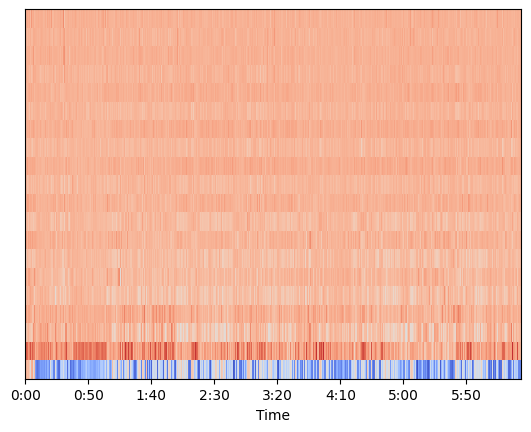

In [ ]:
SR = 8000
for au_nm in df_hl_pre_tr['Аудиофайл']:
  # загрузка аудио
  y, sr = librosa.load(WAV_PAVEL_HL+'/'+au_nm)
  print(f'Частота дискретизации: {sr}')
  print(f'Значения амплитуды: {y}')
  au = librosa.resample(y, orig_sr=sr, target_sr=SR)
  # mfccs = librosa.feature.mfcc(au, sr=8000)
  au_mfcc = librosa.feature.mfcc(y=au, sr=SR) #, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
  print(au_mfcc.shape)
  librosa.display.specshow(au_mfcc, sr=SR, x_axis='time') #Отобразим спектрограммы
  plt.show()#выведим график

  break

- Размер аудио для Частота дискретизации: 22050

In [ ]:
y.shape

(8679539,)

- - Размер аудио для Частота дискретизации: 8000 (исходная частота телефонных звонков)
  - Кстати, звук на слух качественнее, чем после librosa

In [ ]:
au.shape

(3149040,)

In [ ]:
Audio(data=au, rate=8000)

- Попытка нормализации...

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:259: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


[ 7.4421016e-09 -2.9768406e-08  4.9614011e-09  0.0000000e+00
  7.4421016e-09  0.0000000e+00  0.0000000e+00 -4.9614011e-09
 -2.4807005e-09  0.0000000e+00 -9.9228021e-09 -1.4884203e-08
 -2.4807005e-09  4.9614011e-09 -9.9228021e-09  7.4421016e-09
  9.9228021e-09 -9.3026270e-10  4.9614011e-09 -2.4807005e-09]
[0.9999998  0.9999998  0.99999994 1.         0.99999994 1.
 1.0000001  0.9999998  1.         0.99999994 0.9999998  1.
 1.0000001  1.0000001  1.         1.0000001  1.0000001  1.0000001
 1.         1.        ]


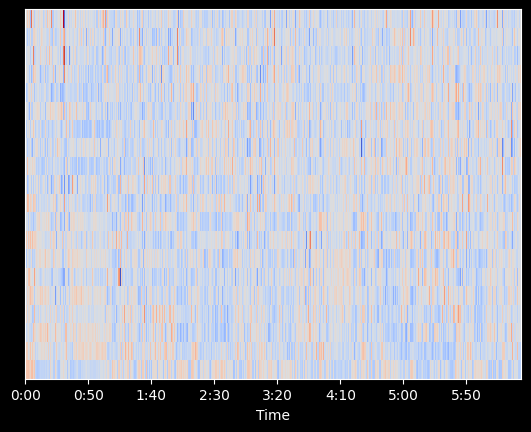

In [ ]:
# Нормируем Мел коэффициенты
au_mfcc_norm = sklearn.preprocessing.scale(au_mfcc, axis=1)
# Выводим среднее значение
print(au_mfcc_norm.mean(axis=1))
# Выводим среднеквадратичное отклонение
print(au_mfcc_norm.var(axis=1))
# Отображаем нормированные коэффициенты
librosa.display.specshow(au_mfcc_norm, sr=SR, x_axis='time') # Отобразим спектрограммы
plt.show() # выведим график

In [ ]:
chroma=librosa.feature.chroma_cens(y=y_harmonic, sr=sr)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chroma,y_axis='chroma', x_axis='time')
plt.colorbar()